In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
from beamline34IDC.optimization import movers, configs, display_utils, common as opt_common
from beamline34IDC.optimization.scipy_nelder_mead import ScipyOptimizer
from beamline34IDC.optimization.skopt_gp import SkoptGaussianProcessOptimizer, SkoptDiscreteGPOptimizer
import beamline34IDC.optimization.movers as movers

from beamline34IDC.optimization.display_utils import LivePlotCallback
from beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import glob
import IPython
from skopt.callbacks import DeltaXStopper, DeltaYStopper, DeadlineStopper

In [3]:
%matplotlib inline

In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

20146


In [5]:
base_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'
temp_work_dir = f'{base_dir}/tmp_work_dir_{DEFAULT_RANDOM_SEED}'

In [6]:
os.mkdir(temp_work_dir)

In [7]:
dat_files = glob.glob(f'{orig_work_dir}/*.dat')
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [8]:
os.chdir(temp_work_dir)

In [9]:
input_beam_path = "primary_optics_system_beam.dat"

In [10]:
move_motors = ['hkb_4', 'vkb_3']

In [11]:
motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

In [18]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

In [19]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

[0. 3.]


In [20]:
deltax = np.inf
for mt in move_motors:
    deltax = np.minimum(deltax, configs.DEFAULT_MOTOR_TOLERANCES[mt] / configs.DEFAULT_MOTOR_RESOLUTIONS[mt])

In [21]:
configs.DEFAULT_MOTOR_TOLERANCES['hkb_3'], configs.DEFAULT_MOTOR_RESOLUTIONS['hkb_3']

(0.0001, 0.0001)

  0%|          | 0/1 [00:00<?, ?it/s]

Initial motor positions are [0.05 4.  ]


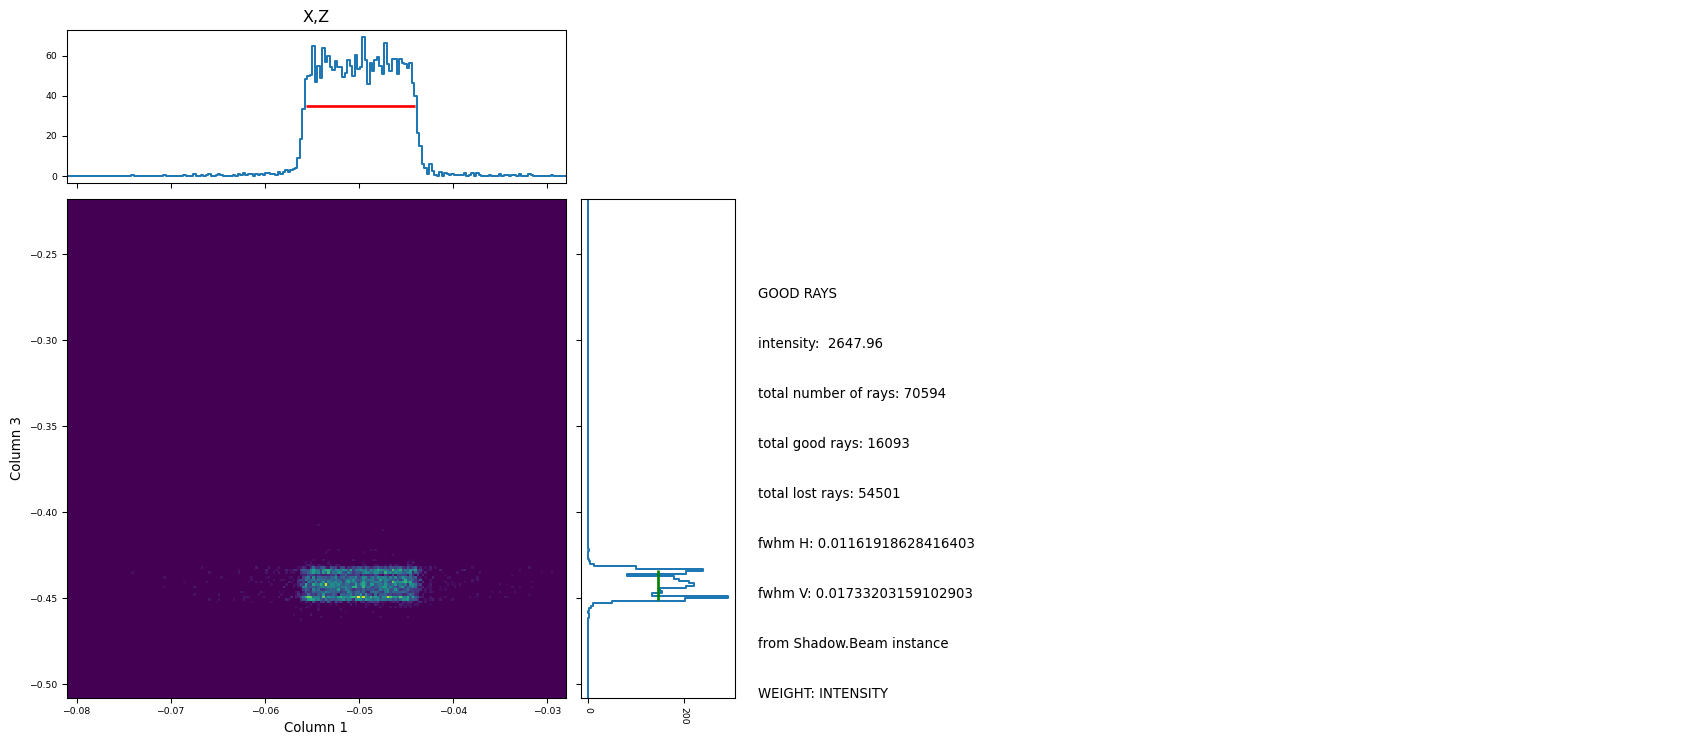

[array([-201,  200]), array([-1000000,   999999])]
Initial loss is 0.4449679753983887


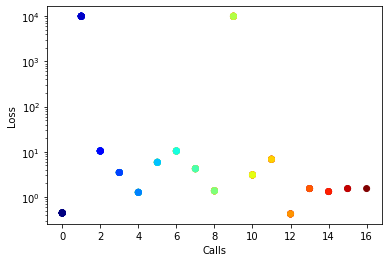

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Loss is 0.4238053309175251 for x [55, -19305] and min acceptable value is 0.0002
Solution is not acceptable.
Trying Nelder-Mead from minimum position
Initial loss is 0.46583433130876595
initial guess is [0.07297783522997098, -41.366728500447124]


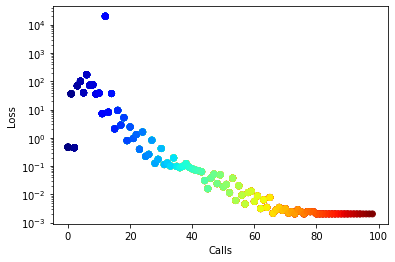

/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Po

Test 0 success False


In [23]:
N_RUNS = 1

initial_centroids = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_centroids = []
final_out_beams = []

for outer in tqdm(range(N_RUNS)):
    translations = [0.05, 1] #np.random.uniform(-0.1, 0.1, size=2)
    test_absolute_movements = initial_absolute_positions + translations
    print("Initial motor positions are", test_absolute_movements)

    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    _ = plot_shadow_beam_spatial_distribution(out_beam)
    
    absolute_movements.append(test_absolute_movements)
    initial_centroids.append(centroid)
    initial_out_beams.append(out_beam)


    opt_trial = SkoptDiscreteGPOptimizer(focusing_system, 
                                          motor_types=move_motors, 
                                          initial_motor_positions=test_absolute_movements, 
                                          random_seed=DEFAULT_RANDOM_SEED)
    
    
    deltax_callback = DeltaXStopper(deltax)
    deadline_callback = DeadlineStopper(180)
    #deltay_callback = DeltaYStopper(configs.DEFAULT_LOSS_TOLERANCES['centroid'])
    plot_callback = display_utils.LivePlotCallback(opt_trial)
    opt_trial.set_optimizer_options(callback = [plot_callback.call, deltax_callback, deadline_callback])#, xi=5e-4, kappa=0.1, n_calls=50)
    opt_results, guesses, solution, success = opt_trial.trials(verbose=False)
    focusing_system = opt_trial.focusing_system
    plot_callback.close()

    if not success:
        sort_args = np.argsort(opt_results[0].func_vals)
        x_simplex = np.array(opt_results[0].x_iters)[sort_args[:len(move_motors) +  1]]
        x_simplex = [opt_trial.transform_to_float(move_motors, xs) for xs in x_simplex]
        
        
        print('Trying Nelder-Mead from minimum position')
        focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
        opt_trial = ScipyOptimizer(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              loss_parameters=['centroid', 'fwhm'])
        plot_callback = display_utils.LivePlotCallback(opt_trial)
        opt_trial.set_optimizer_options(callback = plot_callback.call, initial_simplex=x_simplex)
        
        initial_guess = []
        for mi, mt in enumerate(move_motors):
            initial_guess.append(solution[mi] * configs.DEFAULT_MOTOR_RESOLUTIONS[mt])
                                                                                
        opt_results, guesses, solution, success = opt_trial.trials(1, initial_guess=initial_guess, verbose=False)
        focusing_system = opt_trial.focusing_system
        plot_callback.close()
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    centroid, out_beam, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_centroids.append(centroid)
    final_out_beams.append(out_beam)
    print(f'Test {outer} success {success}')

In [48]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [49]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [50]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [51]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

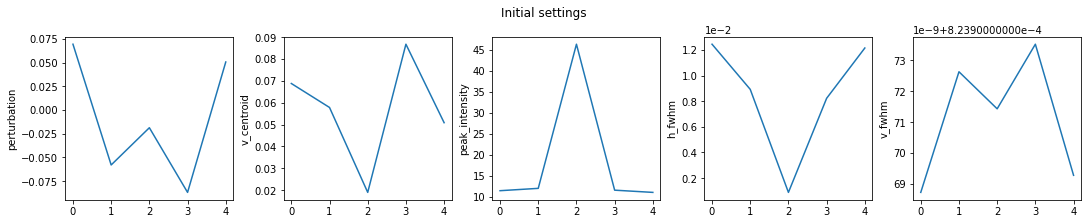

In [52]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('perturbation')

axes[1].plot(initial_centroids)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/initial_metrics.png', bbox_inches='tight')

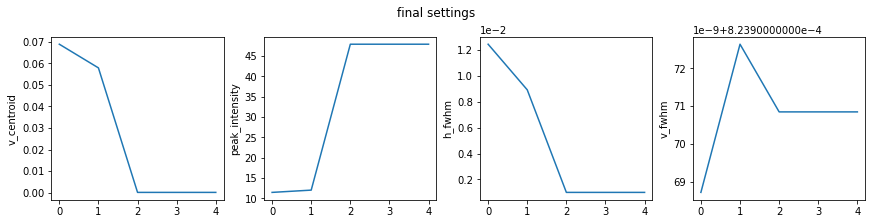

In [53]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_centroids)
axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics.png', bbox_inches='tight')

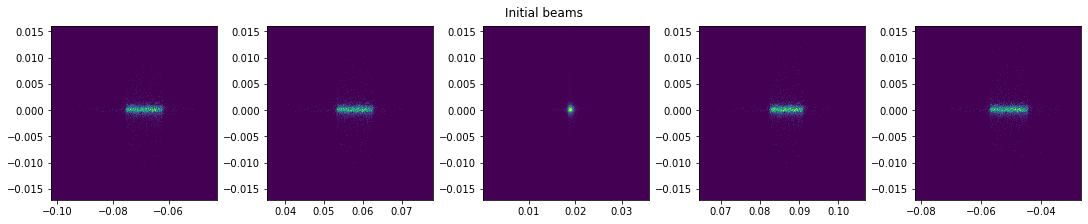

In [54]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/initial_beams.png', bbox_inches='tight')

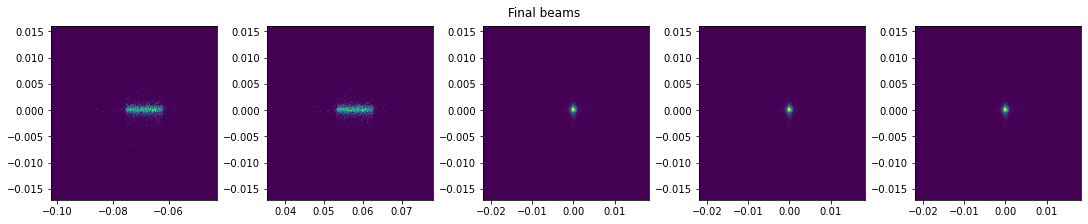

In [55]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams.png', bbox_inches='tight')